Hunter Bennett | Glass Lab | Kupffer Strains Project | 04 June 2021

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [3]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Read in annotation files

In [4]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allNormTags.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

We should filter low intensity peaks because we are not interested in them...

In [33]:
bool_peaks

PeakID
Merged-chr5-122769003-4    False
Merged-chr7-80269644-4     False
Merged-chr9-14074446-4     False
Merged-chr7-35647514-4     False
Merged-chr15-94589888-4    False
                           ...  
Merged-chr18-36401614-1    False
Merged-chr15-78889888-1    False
Merged-chr16-32075119-1    False
Merged-chr17-56076036-1    False
Merged-chr17-28936747-1    False
Length: 137971, dtype: bool

In [5]:
greps = [# 'tag_perfect.*mm10',
         # 'tag_perfect.*balbcj',
         'tag_only.*mm10',
         'tag_only.*balbcj']

thresh = 8
n_passing_thresh = 2
thresh_passing_peaks = []
for grep in greps:
    print(mat.loc[:, (mat.columns.str.contains(grep))].columns)
    bool_peaks = (mat.loc[:, (mat.columns.str.contains(grep))] > thresh).sum(1)>n_passing_thresh
    thresh_passing_peaks.extend(mat.index[bool_peaks])
    
mat_filt = mat.reindex(set(thresh_passing_peaks))

print("N IDR Peaks:", mat.shape[0])
print("N Peaks Passing Thresh:", len(set(thresh_passing_peaks)))
print("N Filtered Peaks:", mat_filt.shape[0])

Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.mm10.bowtie2.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.mm10.bowtie2.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.mm10.bowtie2.sam'],
      dtype='object')
Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam'],
      dtype='object')
N IDR Peaks: 137971
N 

Lets start by looking at the peak intensity distribution for each sample.

In [6]:
greps = ['tag_perfect.*mm10',
         'tag_perfect.*balbcj',
         'tag_only.*mm10',
         'tag_only.*balbcj']

colnames = ['c57bl6j_tag_perfect',
          'balbcj_tag_perfect',
          'c57bl6j_only_muts',
          'balbcj_only_muts']

colors = ['#31a354',
          '#3182bd',
          '#006d2c',
          '#08519c']

Extract average tag values

In [7]:
avg_tag_dict = {}
for grep, colname in zip(greps, colnames):
    avg_tag_dict[colname] = mat_filt.loc[:, mat_filt.columns.str.contains(grep)].mean(1)
    
avg_tag_df = pd.DataFrame(avg_tag_dict)

Extract proportional tag values

In [8]:
avg_tag_df['allelic_bias_perfect'] = avg_tag_df['balbcj_tag_perfect'] / (avg_tag_df['c57bl6j_tag_perfect'] + avg_tag_df['balbcj_tag_perfect'])
avg_tag_df['allelic_bias_only_muts'] = avg_tag_df['balbcj_only_muts'] / (avg_tag_df['c57bl6j_only_muts'] + avg_tag_df['balbcj_only_muts'])

Look at distribution of allelic bias in the mutated peaks

Text(0.5, 1.0, 'Mean First ASB')

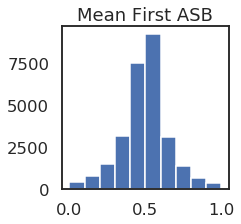

In [10]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(avg_tag_df['allelic_bias_only_muts'].dropna());

ax.set_title('Mean First ASB')

# Check whether allelic bias computation is robust to method
Is calculating allelic bias within an individual then taking the mean equivalent?

In [12]:
samples = ['mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001',
           'mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001',
           'mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001']

prefixes = ['tag_perfect_reads_',
            'tag_only_muts_']

In [13]:
allelic_bias_dict = {}
for samp in samples:
    samp_id = samp.split('_')[8]
    for prefix in prefixes:
        balb = mat_filt.loc[:, prefix+samp+'.balbcj.bowtie2_shifted_from_BALBCJ.sam']
        c57 = mat_filt.loc[:, prefix+samp+'.mm10.bowtie2.sam']
        
        allelic_bias_dict[prefix+samp_id] = balb / (balb+c57)
        
allelic_bias_df = pd.DataFrame(allelic_bias_dict)

only_muts_allelic_bias = allelic_bias_df.loc[:, allelic_bias_df.columns.str.contains('only_muts')]

### Mean-variance relationship for peaks

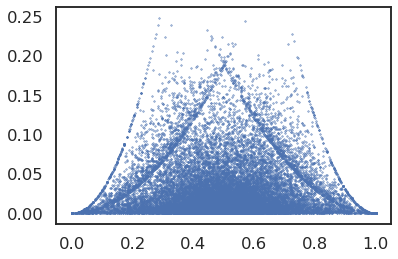

In [14]:
plt.scatter(only_muts_allelic_bias.dropna().mean(1),
            only_muts_allelic_bias.dropna().var(1),
            s=0.3)

How do mean and variance depend on sample expression

In [25]:
avg_tag_df['mean_second_asb_mean'] = only_muts_allelic_bias.dropna().mean(1)
avg_tag_df['mean_second_asb_var'] = only_muts_allelic_bias.dropna().var(1)

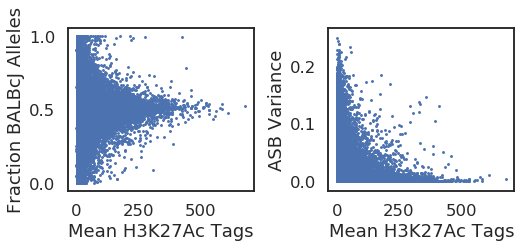

In [32]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(wspace=0.4)

axs[0].scatter(avg_tag_df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               avg_tag_df.loc[:, 'mean_second_asb_mean'],
                              s=2)

axs[0].set_ylabel('Fraction BALBcJ Alleles')
axs[0].set_xlabel('Mean H3K27Ac Tags');

axs[1].scatter(avg_tag_df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               avg_tag_df.loc[:, 'mean_second_asb_var'],
                              s=2)

axs[1].set_ylabel('ASB Variance')
axs[1].set_xlabel('Mean H3K27Ac Tags');

Compare distributions directly

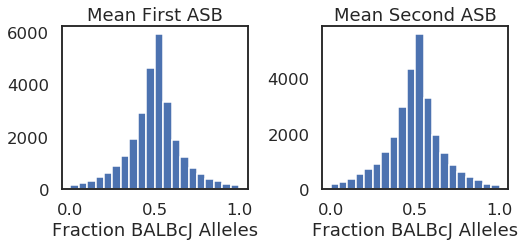

In [23]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(wspace=0.4)

axs[0].hist(avg_tag_df['allelic_bias_only_muts'].dropna(),
            bins=20);
axs[0].set_title('Mean First ASB')
axs[0].set_xlabel('Fraction BALBcJ Alleles');

axs[1].hist(only_muts_allelic_bias.dropna().mean(1),
            bins=20);
axs[1].set_title('Mean Second ASB');
axs[1].set_xlabel('Fraction BALBcJ Alleles');

# Directly compare estimates of allelic bias

In [35]:
avg_tag_df['allelic_bias_only_muts_mean_second'] = only_muts_allelic_bias.mean(1)

Text(0, 0.5, 'Allelic Bias Mean TPM Second')

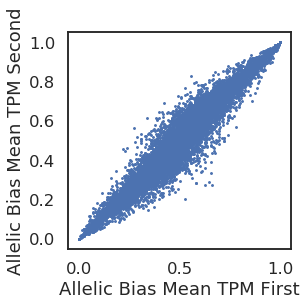

In [36]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(avg_tag_df['allelic_bias_only_muts'],
           avg_tag_df['allelic_bias_only_muts_mean_second'],
           s=2)

ax.set_xlabel('Allelic Bias Mean TPM First')
ax.set_ylabel('Allelic Bias Mean TPM Second')

These do generally agree but there are some big disagreements! We can take a look at them on the genome browser.

In [37]:
avg_tag_df['abs_asb_diff'] = (avg_tag_df['allelic_bias_only_muts'] - avg_tag_df['allelic_bias_only_muts_mean_second']).abs()

In [39]:
df_asb = df.iloc[:, :5].merge(
    avg_tag_df.loc[:, ['c57bl6j_tag_perfect',
                       'balbcj_tag_perfect',
                       'allelic_bias_only_muts',
                       'allelic_bias_only_muts_mean_second',
                       'abs_asb_diff',
                       'mean_second_asb_mean',
                       'mean_second_asb_var']].dropna(),
    left_index=True,
    right_index=True,
    how='right')

df_asb['location'] = df.Chr+':'+df.Start.astype(str)+'-'+df.End.astype(str)

df_asb.to_csv('./peaks_with_asb_min_tag_filter.txt',
              sep='\t')

# Interpretation
Many of the differences look like this, they are due to a single clonal peak in one of the strains that generates a high average allele specific bias when we calculate the means first, but when we calculate pairwise allele specific biases it is brought close to zero by the lack of tags in the other two samples, thus generating a large discrepancy. To adjust for this we will try re-quantifying the peaks with the -pc 3 limiting the number of tags that can be used.

The actual fix was to only filter peaks by ones that had greater than a certain minimum tags in only the tag perfect samples!

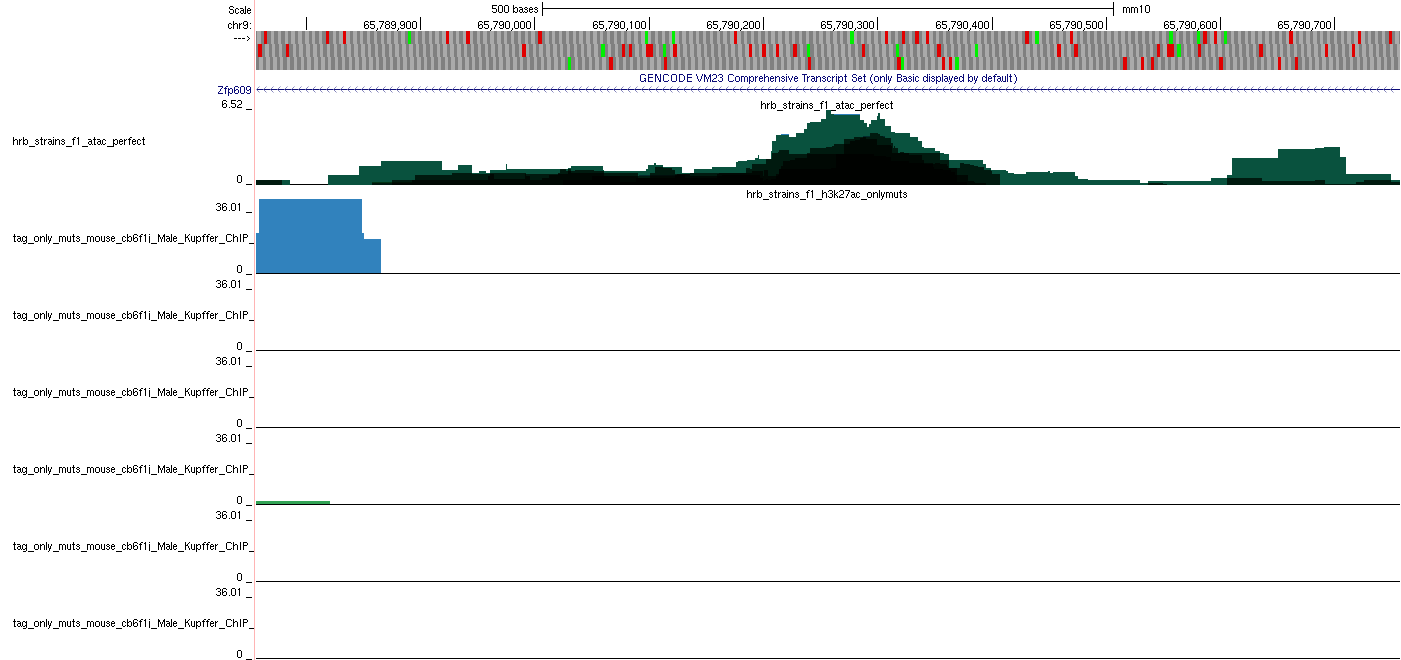